In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import rasterio
from rasterio.sample import sample_gen
from rasterio.enums import Resampling

# Charger le fichier Excel (nécessite le module 'openpyxl')
file_path = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# Renommer la colonne '%' pour éviter les problèmes
df.rename(columns={'%': 'percent'}, inplace=True)

# Convertir certaines colonnes en type numérique
columns_to_convert = ['latitude', 'longitude', 'height', 'ns', 'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)', 'ratio']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Vérifier les colonnes du DataFrame
print(df.columns)

# Supposons que les colonnes 'latitude' et 'longitude' existent dans le fichier
latitude_col = 'latitude'
longitude_col = 'longitude'

# Créer une géométrie de points à partir des colonnes de latitude et longitude
df['geometry'] = df.apply(lambda row: Point(row[longitude_col], row[latitude_col]), axis=1)

# Convertir en GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Supprimer les colonnes de type non compatible pour éviter les erreurs avec le shapefile
columns_to_drop = ['percent']  # Ajouter d'autres colonnes si nécessaire
gdf.drop(columns=columns_to_drop, inplace=True)

# Définir le système de coordonnées (par exemple, WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Spécifier le répertoire de sortie pour sauvegarder le shapefile
output_dir = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'rover_athabasca_2.shp')

# Sauvegarder en tant que shapefile (limiter les noms de colonnes à 10 caractères)
gdf.columns = [col[:10] for col in gdf.columns]
gdf.to_file(output_path, driver='ESRI Shapefile')

print("Conversion en shapefile terminée avec succès.")

# Charger le shapefile généré
gdf = gpd.read_file(output_path)

# Convertir le fichier .tif en float 32 bits
dem_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6.tif"
dem_float32_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6_float32.tif"

# Ouvrir et convertir le .tif en float 32 bits
with rasterio.open(dem_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32)

    with rasterio.open(dem_float32_path, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            data = src.read(i, resampling=Resampling.nearest).astype(rasterio.float32)
            dst.write(data, i)

# Charger le DEM converti
with rasterio.open(dem_float32_path) as dem:
    # Extraire la hauteur du DEM pour chaque point du shapefile
    coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
    gdf['dem_heigh'] = [val[0] for val in dem.sample(coords)]

# Calculer la différence entre la hauteur mesurée et la hauteur du DEM
gdf['heigh_diff'] = gdf['height'] - gdf['dem_heigh']

# Sauvegarder le GeoDataFrame mis à jour (limiter les noms de colonnes à 10 caractères)
gdf.columns = [col[:10] for col in gdf.columns]
gdf.to_file(output_path, driver='ESRI Shapefile')

print("Extraction des données de hauteur du DEM et calcul de la différence terminés avec succès.")

Index(['percent', 'GPST', 'latitude', 'longitude', 'height', 'Q', 'ns',
       'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)',
       'ratio'],
      dtype='object')
Conversion en shapefile terminée avec succès.
Extraction des données de hauteur du DEM et calcul de la différence terminés avec succès.


In [17]:
import numpy as np
import os
import rasterio
import geopandas as gpd

# Path to the DEM file
dem_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6.tif"

# Load the DEM
with rasterio.open(dem_path) as dem:
    # Function to map points to DEM pixels
    def get_pixel(row, dem):
        row, col = dem.index(row.geometry.x, row.geometry.y)
        return row, col

    # Assign each point to the corresponding DEM pixel
    gdf['dem_pixel'] = gdf.apply(lambda row: get_pixel(row, dem), axis=1)

    # Group by DEM pixel and calculate the mean of height, dem_heigh, and height_diff for each pixel
    gdf_grouped = gdf.groupby('dem_pixel').agg(
        mean_height=('height', 'mean'),
        mean_dem_heigh=('dem_heigh', 'mean'),
        mean_height_diff=('heigh_diff', 'mean'),
        point_count=('geometry', 'count')  # Optionally count the number of points per pixel
    ).reset_index()

    # Rename columns to fit the 10-character limit of Shapefile format
    gdf_grouped = gdf_grouped.rename(columns={
        'mean_height': 'mean_heig',
        'mean_dem_heigh': 'mean_dem',
        'mean_height_diff': 'mean_diff',
        'point_count': 'pt_count'
    })

    # Merge back the aggregated data with the original GeoDataFrame
    gdf = gdf.merge(gdf_grouped, on='dem_pixel', how='left')

# Define output directory (set to the user-specified path)
output_dir = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover'

# Save the aggregated data into a new shapefile
output_path_aggregated = os.path.join(output_dir, 'rover_athabasca_aggregated_2.shp')
gdf.to_file(output_path_aggregated, driver='ESRI Shapefile')

# Group by 'dem_heigh' and keep only the first point for each unique DEM altitude
gdf_unique_dem = gdf.drop_duplicates(subset=['dem_heigh'])

# Save the resulting GeoDataFrame with unique DEM altitudes
output_path_unique = os.path.join(output_dir, 'rover_athabasca_unique_dem.shp')
gdf_unique_dem.to_file(output_path_unique, driver='ESRI Shapefile')

print("Aggregation by DEM pixel and calculation of means completed successfully.")
print("GeoDataFrame with unique DEM altitudes saved successfully.")


Aggregation by DEM pixel and calculation of means completed successfully.
GeoDataFrame with unique DEM altitudes saved successfully.


C:\Users\thier\AppData\Local\Temp\ipykernel_63044\2234294000.py:43: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path_aggregated, driver='ESRI Shapefile')
c:\Users\thier\miniforge3\envs\geospatial_env\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'mean_height' to 'mean_hei_2'
  ogr_write(
c:\Users\thier\miniforge3\envs\geospatial_env\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'mean_dem_heigh' to 'mean_dem_1'
  ogr_write(
c:\Users\thier\miniforge3\envs\geospatial_env\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'mean_height_diff' to 'mean_hei_3'
  ogr_write(
c:\Users\thier\miniforge3\envs\geospatial_env\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'point_count' to 'point_co_1'
  ogr_write(
C:\Users\thier\AppData\Local\Temp\ipykernel_63044\2234294

C:\Users\thier\AppData\Local\Temp\ipykernel_63044\3834506880.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  {'geometry': [gdf_sorted.geometry.unary_union.convex_hull]},


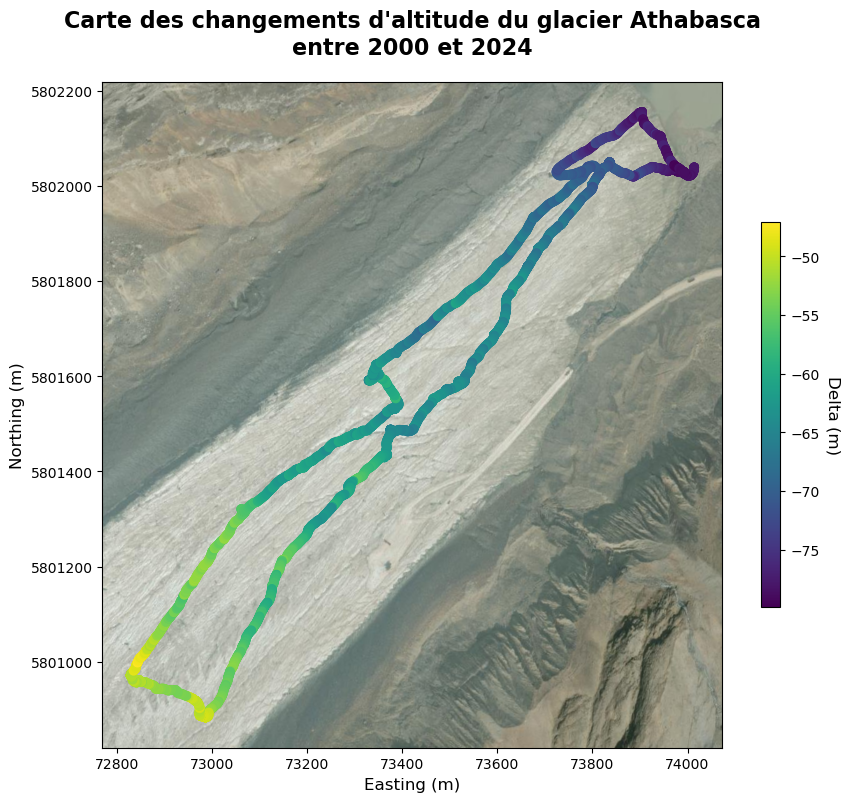

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Charger le fichier shapefile
# Le chemin d'accès au fichier shapefile contenant les données des points GNSS
gdf = gpd.read_file(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca_2.shp')

# Convertir les points en lignes
# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Créer une ligne à partir des points triés
# Utiliser 'unary_union' pour fusionner tous les points en une seule géométrie, puis prendre l'enveloppe convexe (convex hull) pour créer une ligne
# Cela est utile pour avoir une représentation générale des points en tant que ligne
gdf_line = gpd.GeoDataFrame(
    {'geometry': [gdf_sorted.geometry.unary_union.convex_hull]},
    crs=gdf.crs
)

# Créer une carte graduée pour représenter les changements d'altitude
# Reprojeter les données dans le système de coordonnées UTM (par exemple, EPSG:32612 pour UTM zone 12N)
gdf_sorted = gdf_sorted.to_crs(epsg=32612)

# Initialiser la figure et les axes pour la carte
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les lignes et utiliser la colonne 'heigh_diff' pour la couleur
# Représenter les différences d'altitude en utilisant un dégradé de couleurs (cmap='viridis')
gdf_sorted.plot(ax=ax, column='heigh_diff', cmap='viridis', legend=True, linewidth=1, legend_kwds={'shrink': 0.5})

# Ajouter une légende qui spécifie le delta en mètre
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Delta (m)', rotation=270, labelpad=15, fontsize=12)

# Ajouter une basemap satellite pour donner un contexte géographique
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf_sorted.crs, attribution="")
# Convertir les ticks des axes en coordonnées UTM
ax.set_xlabel("Easting (m)", fontsize=12)  # Étiquette de l'axe X en UTM avec taille de police
ax.set_ylabel("Northing (m)", fontsize=12)  # Étiquette de l'axe Y en UTM avec taille de police
ax.ticklabel_format(useOffset=False, style='plain')  # Désactiver le décalage et afficher les coordonnées en style normal

# Afficher la carte avec le titre
plt.title("Carte des changements d'altitude du glacier Athabasca\nentre 2000 et 2024", fontsize=16, fontweight='bold', pad=20)
plt.show()

In [ ]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from matplotlib.patches import Rectangle

# Charger le fichier shapefile
gdf = gpd.read_file(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca_2.shp')

# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Transformer les coordonnées en UTM (zone 12N, par exemple EPSG:32612)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
gdf_sorted['utm_x'], gdf_sorted['utm_y'] = transformer.transform(gdf_sorted.geometry.x, gdf_sorted.geometry.y)

# Calculer la distance cumulative entre les points
gdf_sorted['distance'] = np.sqrt((gdf_sorted['utm_x'].diff()**2) + (gdf_sorted['utm_y'].diff()**2))
gdf_sorted['distance_cumulative'] = gdf_sorted['distance'].cumsum().fillna(0)

# Calculer la distance par rapport au front du glacier (point avec id 0)
front_x = gdf_sorted.iloc[0]['utm_x']
front_y = gdf_sorted.iloc[0]['utm_y']
gdf_sorted['distance_from_front'] = np.sqrt((gdf_sorted['utm_x'] - front_x)**2 + (gdf_sorted['utm_y'] - front_y)**2)

# Assurer que les colonnes 'height1' et 'height2' sont présentes
gdf_sorted['height1'] = gdf_sorted['height']
gdf_sorted['height2'] = gdf_sorted['dem_heigh']

# Calculer la différence de hauteur
gdf_sorted['height_diff'] = gdf_sorted['height2'] - gdf_sorted['height1']

# Filtrer les points jusqu'à l'ID 5191 (distance maximale atteinte par le glacier)
gdf_filtered = gdf_sorted.iloc[:5192]

# Tracer le graphique représentant la différence de hauteur en fonction de la distance par rapport au front du glacier
fig, ax = plt.subplots(figsize=(18, 12))

# Tracer la différence de hauteur en négatif
ax.plot(gdf_filtered['distance_from_front'], -gdf_filtered['height_diff'], label='Différence de hauteur', color='g', linestyle='-', marker='o', markersize=4)

# Ajouter des labels et un titre au graphique avec une police plus grande
ax.set_xlabel('Distance par rapport au front du glacier (m)', fontsize=20, fontweight='bold')
ax.set_ylabel('Différence de hauteur (m)', fontsize=20, fontweight='bold')
ax.set_title('Différence de hauteur entre 2000 et 2024 le long du trajet GNSS \npar rapport au front du glacier Athabasca', fontsize=28, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=18, loc='best')

# Augmenter la police des ticks
ax.tick_params(axis='both', which='major', labelsize=16)

# Inverser l'axe des y pour avoir une échelle décroissante
ax.invert_yaxis()

# Inverser l'axe des x pour avoir une échelle décroissante
ax.invert_xaxis()

# Ajouter une bordure noire autour du layout sans changer la taille du layout
fig.patch.set_linewidth(3)
fig.patch.set_edgecolor('black')

plt.tight_layout()
plt.savefig('height_difference_plot.png', dpi=300)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import numpy as np
from scipy.interpolate import make_interp_spline

# Charger les fichiers .shp simulé (ici j'utilise l'exemple existant)
shp_path = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca_2.shp'
sf = shapefile.Reader(shp_path)

# Extraire les champs de données
fields = [x[0] for x in sf.fields][1:]
records = sf.records()

# Convertir les données en DataFrame
shapefile_data = pd.DataFrame(records, columns=fields)

# Identifier l'index où l'altitude atteint son maximum (fin de l'aller)
max_altitude_index = shapefile_data['height'].idxmax()

# Filtrer les données jusqu'à ce point (avant que l'altitude ne diminue)
filtered_data_aller = shapefile_data.loc[:max_altitude_index]

# Extraire les colonnes d'altitude et de différence de hauteur pour le transect aller
altitude_aller = filtered_data_aller['height']
hauteur_diff_aller = filtered_data_aller['heigh_diff']

# Supprimer les doublons dans les altitudes
altitude_aller_unique, unique_indices = np.unique(altitude_aller, return_index=True)
hauteur_diff_aller_unique = hauteur_diff_aller.iloc[unique_indices]

# Créer une interpolation pour lisser la courbe
xnew = np.linspace(altitude_aller_unique.min(), altitude_aller_unique.max(), 100)  # Plus de points pour un lissage
spl = make_interp_spline(altitude_aller_unique, hauteur_diff_aller_unique, k=3)  # Interpolation cubique
hauteur_diff_smooth = spl(xnew)

# Créer le graphique pour le transect aller avec une courbe lissée
plt.figure(figsize=(10, 6))
plt.plot(xnew, hauteur_diff_smooth, linestyle='-', color='b')
plt.title("Différence de hauteur en fonction de l'altitude sur\nle glacier Athabasca entre 2000 et 2024", fontsize=16, fontweight='bold')
plt.xlabel("Altitude (m)", fontsize=14, fontweight='bold')
plt.ylabel("Différence de hauteur (m)", fontsize=14, fontweight='bold')
plt.grid(True)
plt.gca().invert_yaxis()  # Inverser l'axe des y
plt.tight_layout()
plt.savefig('height_difference_vs_altitude.png', dpi=300)
plt.show()

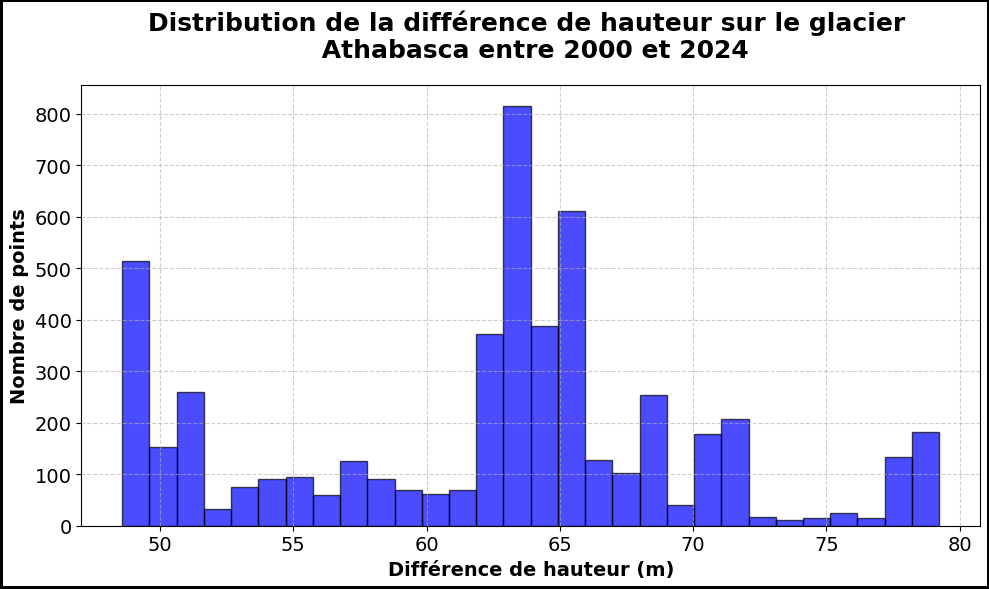

In [32]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from matplotlib.patches import Rectangle

# Charger le fichier shapefile
gdf = gpd.read_file(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca_2.shp')

# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Transformer les coordonnées en UTM (zone 12N, par exemple EPSG:32612)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
gdf_sorted['utm_x'], gdf_sorted['utm_y'] = transformer.transform(gdf_sorted.geometry.x, gdf_sorted.geometry.y)

# Calculer la distance cumulative entre les points
gdf_sorted['distance'] = np.sqrt((gdf_sorted['utm_x'].diff()**2) + (gdf_sorted['utm_y'].diff()**2))
gdf_sorted['distance_cumulative'] = gdf_sorted['distance'].cumsum().fillna(0)

# Calculer la distance par rapport au front du glacier (point avec id 0)
front_x = gdf_sorted.iloc[0]['utm_x']
front_y = gdf_sorted.iloc[0]['utm_y']
gdf_sorted['distance_from_front'] = np.sqrt((gdf_sorted['utm_x'] - front_x)**2 + (gdf_sorted['utm_y'] - front_y)**2)

# Assurer que les colonnes 'height1' et 'height2' sont présentes
gdf_sorted['height1'] = gdf_sorted['height']
gdf_sorted['height2'] = gdf_sorted['dem_heigh']

# Calculer la différence de hauteur
gdf_sorted['height_diff'] = gdf_sorted['height2'] - gdf_sorted['height1']

# Filtrer les points jusqu'à l'ID 5191 (distance maximale atteinte par le glacier)
gdf_filtered = gdf_sorted.iloc[:5192]

# Tracer l'histogramme de la différence de hauteur
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(gdf_filtered['height_diff'], bins=30, color='blue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Différence de hauteur (m)', fontsize=14, fontweight='bold')
ax.set_ylabel('Nombre de points', fontsize=14, fontweight='bold')
ax.set_title('Distribution de la différence de hauteur sur le glacier \n Athabasca entre 2000 et 2024', fontsize=18, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Augmenter la police des ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Ajouter une bordure noire autour du layout sans changer la taille du layout
fig.patch.set_linewidth(3)
fig.patch.set_edgecolor('black')

plt.tight_layout()
plt.savefig('height_difference_histogram.png', dpi=300)
plt.show()


In [18]:
gdf

,GPST,latitude,longitude,height,Q,ns,sdn(m),sde(m),sdu(m),sdne(m),...,point_coun,geometry,mean_height,mean_dem_heigh,mean_height_diff,point_count,mean_heig,mean_dem,mean_diff,pt_count
0,20:40:48,52.203640,-117.236538,1961.9281,2,9,0.0081,0.0078,0.0330,0.0032,...,102,POINT (-117.23654 52.20364),1961.9281,2040.0,-78.0719,1,1961.9281,2040.0,-78.0719,1
1,20:42:30,52.203485,-117.236738,1962.2380,1,9,0.0053,0.0039,0.0144,0.0012,...,123,POINT (-117.23674 52.20348),1962.2380,2041.0,-78.7620,1,1962.2380,2041.0,-78.7620,1
2,20:42:51,52.203533,-117.237017,1963.0422,1,9,0.0077,0.0056,0.0209,0.0019,...,153,POINT (-117.23702 52.20353),1963.0422,2042.0,-78.9578,1,1963.0422,2042.0,-78.9578,1
3,20:45:15,52.203546,-117.237280,1964.3792,1,9,0.0054,0.0040,0.0148,0.0010,...,48,POINT (-117.23728 52.20355),1964.3792,2043.0,-78.6208,1,1964.3792,2043.0,-78.6208,1
4,20:46:03,52.203569,-117.237556,1966.3433,1,9,0.0053,0.0038,0.0147,0.0009,...,19,POINT (-117.23756 52.20357),1966.3433,2044.0,-77.6567,1,1966.3433,2044.0,-77.6567,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,22:39:48,52.203253,-117.239968,1987.7986,1,11,0.0071,0.0053,0.0141,-0.0036,...,15,POINT (-117.23997 52.20325),1987.7986,2057.0,-69.2014,1,1987.7986,2057.0,-69.2014,1
102,22:40:02,52.203400,-117.239830,1985.6729,1,11,0.0070,0.0053,0.0140,-0.0038,...,34,POINT (-117.23983 52.2034),1985.6729,2056.0,-70.3271,1,1985.6729,2056.0,-70.3271,1
103,22:43:28,52.204098,-117.239142,1973.1908,1,11,0.0073,0.0047,0.0137,-0.0036,...,14,POINT (-117.23914 52.2041),1973.1908,2047.0,-73.8092,1,1973.1908,2047.0,-73.8092,1
104,22:46:23,52.204206,-117.237808,1962.8100,1,11,0.0074,0.0050,0.0134,-0.0037,...,2,POINT (-117.23781 52.20421),1962.8100,2038.0,-75.1900,1,1962.8100,2038.0,-75.1900,1


                            OLS Regression Results                            
Dep. Variable:              mean_diff   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     611.2
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           2.41e-45
Time:                        16:46:05   Log-Likelihood:                -246.83
No. Observations:                 106   AIC:                             497.7
Df Residuals:                     104   BIC:                             503.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -327.5445     10.633    -30.804      0.0

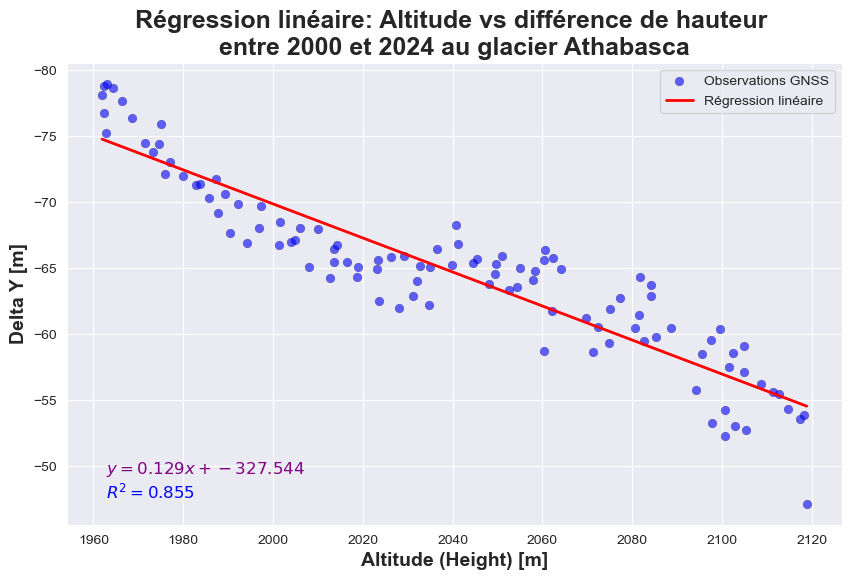

In [29]:
import geopandas as gpd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the shapefile
shapefile_path = r"D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca_aggregated_2.shp"
gdf = gpd.read_file(shapefile_path)

# Fit a linear regression model to examine the relationship between height difference and altitude for Athabasca glacier
model_athabasca = ols('mean_diff ~ mean_heig', data=gdf).fit()

# Display the summary of the regression analysis
print(model_athabasca.summary())

# Generate values for the fitted linear regression line
x_athabasca = np.linspace(gdf['mean_heig'].min(), gdf['mean_heig'].max(), 500)
x_df_athabasca = gpd.GeoDataFrame({'mean_heig': x_athabasca})
y_pred_athabasca = model_athabasca.predict(exog=x_df_athabasca)

sns.set_style("darkgrid")

# Plotting the scatter plot with the fitted linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_heig', y='mean_diff', data=gdf, alpha=0.6, color='b', s=40, label='Observations GNSS', edgecolor='black', linewidth=0.2)
plt.plot(x_athabasca, y_pred_athabasca, color='r', linestyle='-', linewidth=2, label='Régression linéaire')
plt.legend(fontsize=12)

# Adding R² value to the plot
r_squared_athabasca = model_athabasca.rsquared
plt.text(0.05, 0.05, f'$R^2 = {r_squared_athabasca:.3f}$', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color='blue', verticalalignment='bottom')

# Adding regression equation to the plot
intercept_athabasca = model_athabasca.params['Intercept']
slope_athabasca = model_athabasca.params['mean_heig']
plt.text(0.05, 0.10, f'$y = {slope_athabasca:.3f}x + {intercept_athabasca:.3f}$', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color='purple', verticalalignment='bottom')

plt.xlabel('Altitude (Height) [m]', fontsize=14, fontweight='bold')
plt.ylabel('Delta Y [m]', fontsize=14, fontweight='bold')
plt.title('Régression linéaire: Altitude vs différence de hauteur \nentre 2000 et 2024 au glacier Athabasca', fontsize=18, fontweight='bold')
plt.legend()
plt.grid(True)

# Invert the Y-axis
plt.gca().invert_yaxis()

plt.show()